# Фильтр Калмана, интерполяция c положительными данными



### Библиотеки:

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ma
from pykalman import KalmanFilter
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import os
import matplotlib.transforms as mtransforms

 ### данные с пропусками

In [8]:
data = pd.read_csv('C:/pythonushka/my_new_file999.csv')
data['date'] = data.index
#length_colulmn = len(data)
#for i in range(1,length_colulmn):
#    if data['value'].iloc[i]-data['value'].iloc[i-1] <0:
#        data['value'].iloc[i] = data['value'].iloc[i-1]
#    elif data['value'].iloc[i]-data['value'].iloc[i+1] <0:
#        data['value'].iloc[i] = data['value'].iloc[i+1]   
#    else: 
#        data['value'].iloc[i] = data['value'].iloc[i]

print(data)
print(data.info())


      date       value
0        0     116.082
1        1         NaN
2        2         NaN
3        3         NaN
4        4         NaN
...    ...         ...
1456  1456         NaN
1457  1457         NaN
1458  1458         NaN
1459  1459         NaN
1460  1460  723052.369

[1461 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1461 non-null   int64  
 1   value   1088 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 23.0 KB
None


<AxesSubplot:xlabel='date'>

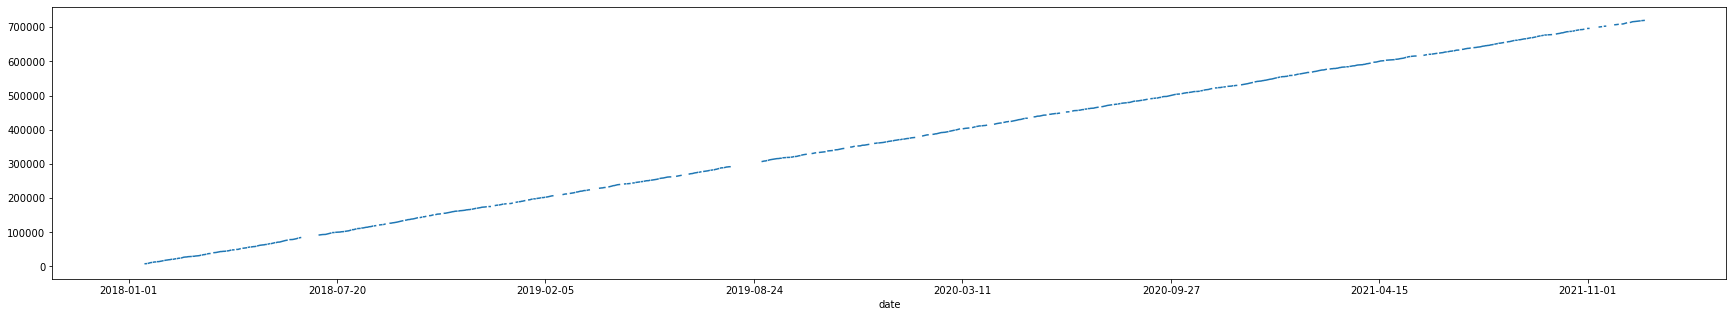

In [23]:
data = pd.read_csv('C:/pythonushka/my_new_file999.csv')
data.set_index('date')['value'].plot(figsize=(30, 5))

<AxesSubplot:xlabel='date'>

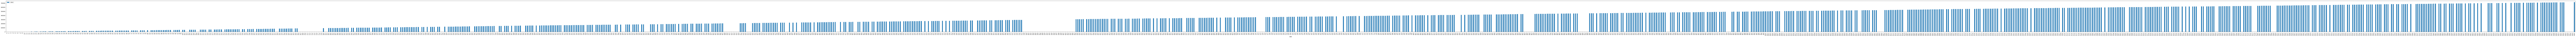

In [6]:
data.plot.bar(x='date', y='value', figsize=(400,5))

## интерполяция

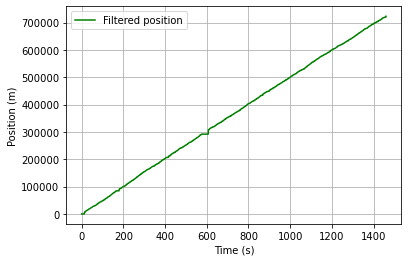

In [25]:
data = pd.read_csv('C:/pythonushka/my_new_file999.csv')
data['date'] = data.index

data['index'] = data.index
data['value'].fillna(0, inplace = True)
# включить или отключить отсутствующие наблюдения
use_mask = 1

Time=[]
X=[]
data['value'].fillna(0, inplace=True)
value = data['value'].to_list()
indexer = data['index'].to_list()


for line in indexer:
    f1  = line
    Time.append(float(f1))

for line1 in value:    
    f2 = line1
    X.append(float(f2))

if (use_mask):
    X = ma.asarray(X)
    X = ma.masked_where(X <= 1, X)

# здесь мы замаскеровали данные по value, чтобы сработала функция    

# Конфигурация фильтра


# шаг времени
dt = Time[2] - Time[1]

# переходная матрица
# здесь подобраны параметры изходя из подбора, в котором наши предсказуемые значения не превышали последующих значений  

F = [[1,  1.111*dt, 2*dt*dt], 
     [0,   1,      1.111*dt],
     [0,   0,            1]]  


# матрица наблюдения
H = [1, 0, 0]

# переходная ковариация
Q = [[   1,     0,     0], 
     [   0,  1e-13,     0],
     [   0,     0,  1e-15]] 

# ковариация наблюдения
R = [0] # max error = 0 m

# начальное состояние означает
X0 = [0,
      0,
      0]

# Ковариация начального состояния
P0 = [[  1,    0,   0], 
      [  0,    1,   0],
      [  0,    0,   1]]

n_timesteps = len(Time)
n_dim_state = 3



filtered_state_means = np.zeros((n_timesteps, n_dim_state))
filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))

# Инициализация Kalman-Filter
kf = KalmanFilter(transition_matrices = F, 
                  observation_matrices = H, 
                  transition_covariance = Q, 
                  observation_covariance = R, 
                  initial_state_mean = X0, 
                  initial_state_covariance = P0)


# Итеративная оценка для каждого нового измерения

for t in range(n_timesteps):
    filtered_state_means[t], filtered_state_covariances[t] = (
    kf.filter_update(
            filtered_state_means[t-1],
            filtered_state_covariances[t-1],
            observation = X[t])
        )

position_sigma = np.sqrt(filtered_state_covariances[:, 0, 0]);        


# график полученной траектории
plt.plot(Time, filtered_state_means[:, 0], "g-", label="Filtered position", markersize=1)
#plt.plot(Time, filtered_state_means[:, 0] + position_sigma, "r--", label="+ sigma", markersize=1)
#plt.plot(Time, filtered_state_means[:, 0] - position_sigma, "r--", label="- sigma", markersize=2)
plt.grid()
plt.legend(loc="upper left")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.show() 

In [26]:
data = pd.read_csv('C:/pythonushka/my_new_file999.csv')
#print(filtered_state_means[:, 0])
value2 = []
value2.append(filtered_state_means[:, 0])
data['value2'] = filtered_state_means[:, 0]
#print(data)


data['delta'] = data['value2'].T.diff().fillna(0).astype('float64')  
#print(data['delta'])

# Функция покажет если есть предыдущие значения больше последующих

data_delta_age_negative = data [data ['delta'] <0]
data.pop('date')
data.pop('value')
data.pop('delta')
#data['index'] = data.index +1
data['index2'] = data.index +1


print('Наличие значений превышающих последующие:',data_delta_age_negative)
data.pop('index2')
data['date'] = data.index


#length_colulmn = len(data)

#for i in range(1,length_colulmn):
#    if data['value2'].iloc[i]-data['value2'].iloc[i-1] <0:
#        data['value2'].iloc[i] = data['value2'].iloc[i-1]
#    elif data['value2'].iloc[i]-data['value2'].iloc[i+1] <0:
#        data['value2'].iloc[i] = data['value2'].iloc[i+1]   
#    else: 
#        data['value2'].iloc[i] = data['value2'].iloc[i]
data.to_csv('C:/pythonushka/kalman_norm_data.csv', index=False)


Наличие значений превышающих последующие: Empty DataFrame
Columns: [date, value, value2, delta]
Index: []


#### В итоге мы видим,  что значений превышающих последующие нет 

In [27]:
print(data)
print(data.info())

             value2  date
0        116.082000     0
1        116.082000     1
2        116.082000     2
3        116.082000     3
4        116.082000     4
...             ...   ...
1456  719952.995992  1456
1457  719953.413059  1457
1458  719953.830507  1458
1459  719954.248334  1459
1460  723052.369000  1460

[1461 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value2  1461 non-null   float64
 1   date    1461 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 23.0 KB
None


<AxesSubplot:xlabel='date'>

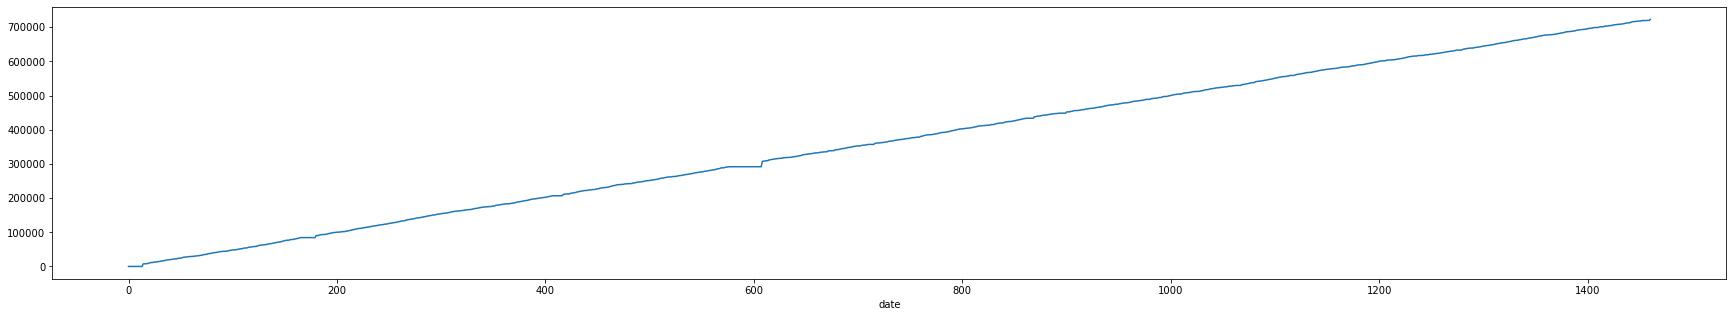

In [21]:
data.set_index('date')['value2'].plot(figsize=(30, 5))

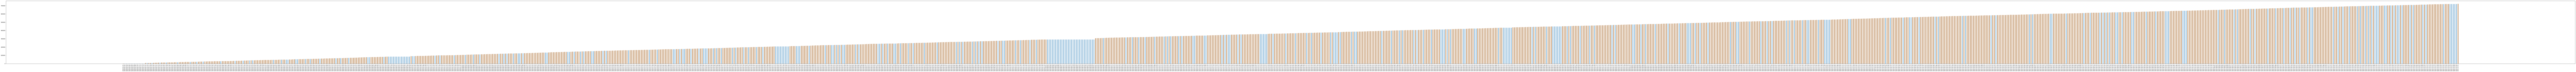

In [22]:
missing = pd.read_csv('C:/pythonushka/my_new_file999.csv')

w=0.5
x = missing['date']
value = data['value2']
value2 = missing['value']

#bar1 = np.arange(len(x))
#bar2 = [i+w for i in bar1]

plt.bar(x, value, w, alpha=0.5)
plt.bar(x, value2, w, alpha=0.5)

plt.gcf().set_size_inches(400, 10)
plt.xticks(x, rotation = 90)
plt.show()


### По графикам можно увидеть, что данные все восстановлены, однако есть моменты, в которых данная модель имеет минусы, это промежутки, где некоторое время значения равно предедущим, это происходит из-за того что пропуски слишком длинные, однако значения которые пропущены единежды или их не так много, модель предсказывает(восстанавливает) очень хорошо.

In [ ]:
data['detvalue'] = data.value2

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(16, 8)
sns.distplot(missing["value"].dropna(), kde = False)
sns.distplot(data['detvalue'], kde = False, color = 'red')
    
plt.tight_layout()

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(16, 8)

df_all = pd.concat([missing, data['detvalue']])
#sns.boxplot(data=result, hue='method')
#df_all = pd.concat([df1,df2])
sns.boxplot(data=df_all)

In [ ]:
pd.concat([missing[["value"]], data[["detvalue"]]], axis = 1).describe().T

In [ ]:
print(missing["value"].std() - data["detvalue"].std())

# 1079.5482456645113

# Вывод:

Модель хорошая

Мы можем представить себе этот факт разными способами. 
Первый - это построение гистограмм как для неполных, так и для полных данных, 
на которых мы можем заметить, что график полных данных выше и уже по сравнению с графиком неполных данных. 
Другими словами, полные данные имеют меньшее стандартное отклонение (следовательно, меньшую изменчивость), 
чем неполные данные. Другой метод - построить коробчатую диаграмму, 
на которой мы можем наблюдать, что диапазон IQ довольно сжат для полных данных по сравнению с таковым в неполных данных.

### Следовательно этот метод имеет место быть, им можно пользоваться, но для идеального восстановления данных с 